<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/ChurnPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Marketing Series: Customer Churn

### 1. Downloading Dataset

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d arashnic/marketing-series-customer-churn

  0% 0.00/171k [00:00<?, ?B/s]
100% 171k/171k [00:00<00:00, 51.6MB/s]


#### Dataset Context
> Use customer data from a telecom to predict which customers will stop being customers (churn) and those that will remain customers

In [3]:
!unzip -q marketing-series-customer-churn.zip

In [4]:
import pandas as pd

In [5]:
dataset = pd.read_csv('train.csv')
dataset.head()

,CustomerID,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,7590-VHVEG,0,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,1,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,1,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,1,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,0,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2. Data Visualization

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
palette = sns.cubehelix_palette(start=.5, rot=-.5)
sns.set_palette(palette=palette)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['figure.max_open_warning'] = 1
plt.rc('figure', titlesize = 18)

#### 2.1 Missing Data

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         6499 non-null   object 
 1   Gender             6499 non-null   int64  
 2   Senior Citizen     6499 non-null   int64  
 3   Partner            6499 non-null   object 
 4   Dependents         6499 non-null   object 
 5   Tenure             6499 non-null   int64  
 6   Phone Service      6499 non-null   object 
 7   Multiple Lines     6499 non-null   object 
 8   Internet Service   6499 non-null   object 
 9   Online Security    6499 non-null   object 
 10  Online Backup      6499 non-null   object 
 11  Device Protection  6499 non-null   object 
 12  Tech Support       6499 non-null   object 
 13  Streaming TV       6499 non-null   object 
 14  Streaming Movies   6499 non-null   object 
 15  Contract           6499 non-null   object 
 16  Paperless Billing  6499 

In [9]:
dataset.isna().sum()[dataset.isna().sum() > 0]

Total Charges    9
dtype: int64

In [10]:
categorical_cols = dataset.select_dtypes('object').columns.drop(['CustomerID', 'Churn'])
categorical_cols = categorical_cols.tolist() + ['Gender', 'Senior Citizen', 'Tenure']
numerical_cols = dataset.select_dtypes(np.number).columns.drop(['Gender', 'Senior Citizen', 'Tenure']).tolist()

#### 2.2 Visualize dataset

Ration of churning

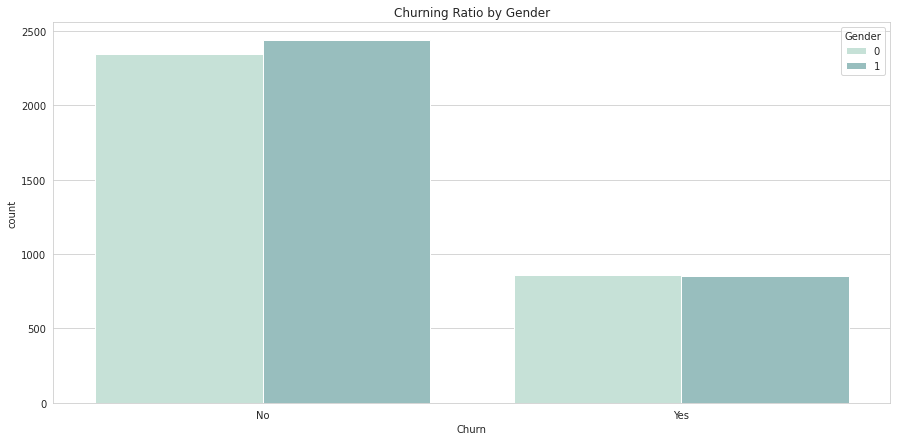

In [11]:
sns.countplot(x=dataset.Churn, hue=dataset.Gender)
plt.title('Churning Ratio by Gender');

Charges Density Distribution

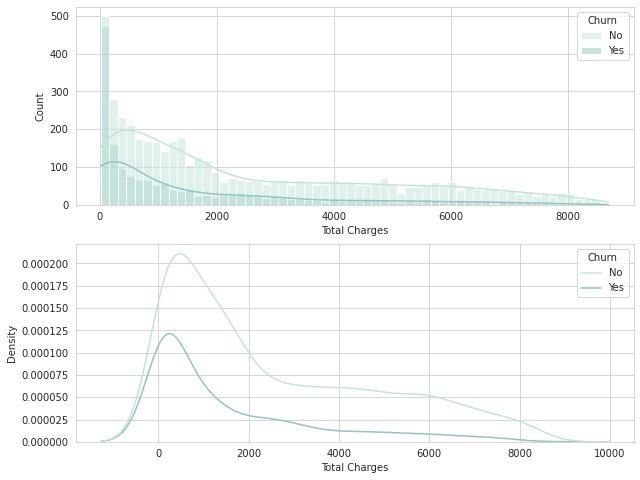

In [12]:
f, ax = plt.subplots(2, 1, figsize=(10, 8))
sns.histplot(data=dataset, x='Total Charges', bins=60, kde=True, hue='Churn', ax=ax[0]);
sns.kdeplot(data=dataset, x='Total Charges', hue='Churn', ax=ax[1]);

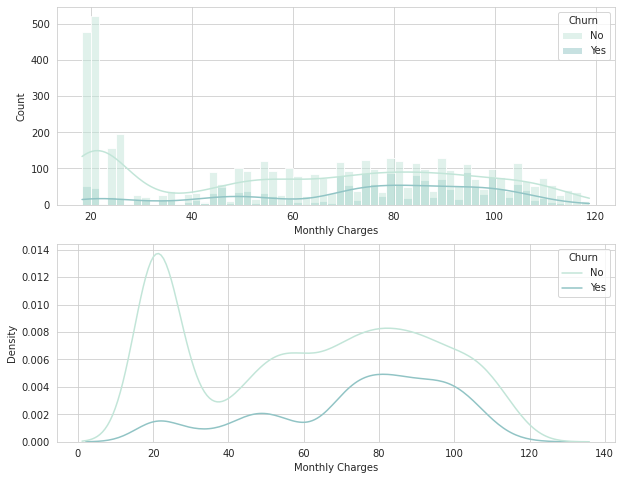

In [13]:
f, ax = plt.subplots(2, 1, figsize=(10, 8))
sns.histplot(data=dataset, x='Monthly Charges', bins=60, kde=True, hue='Churn', ax=ax[0]);
sns.kdeplot(data=dataset, x='Monthly Charges', hue='Churn', ax=ax[1]);

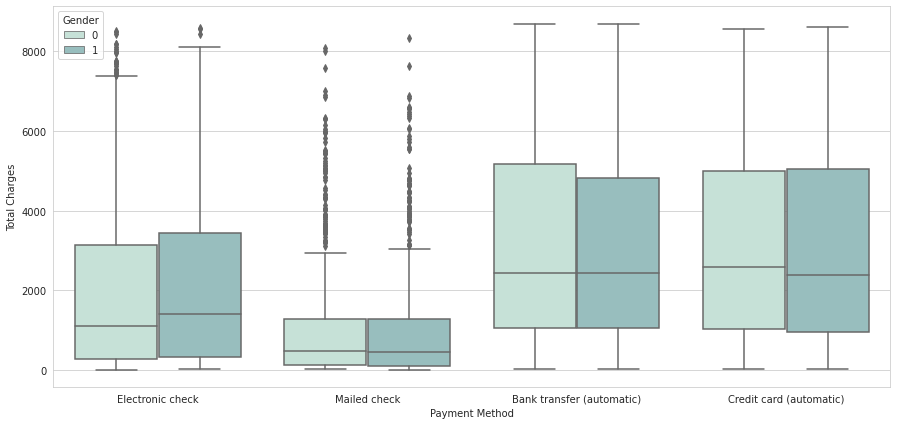

In [14]:
sns.boxplot(data=dataset, x='Payment Method', y='Total Charges', hue='Gender')

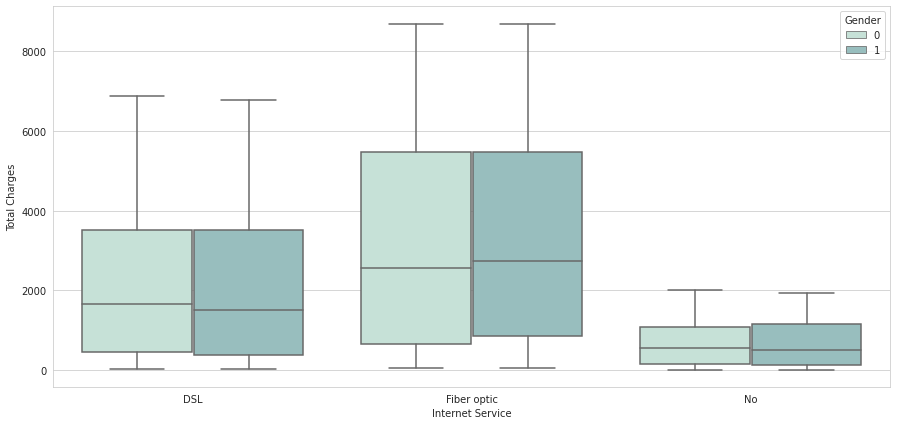

In [15]:
sns.boxplot(data=dataset, x='Internet Service', y='Total Charges', hue='Gender')

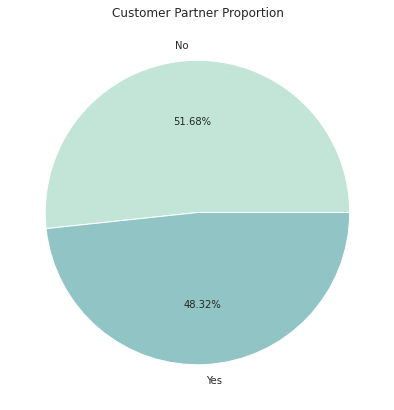

In [16]:
plt.pie(dataset.Partner.value_counts(), labels=['No', 'Yes'], autopct="%.2f%%")
plt.title('Customer Partner Proportion');

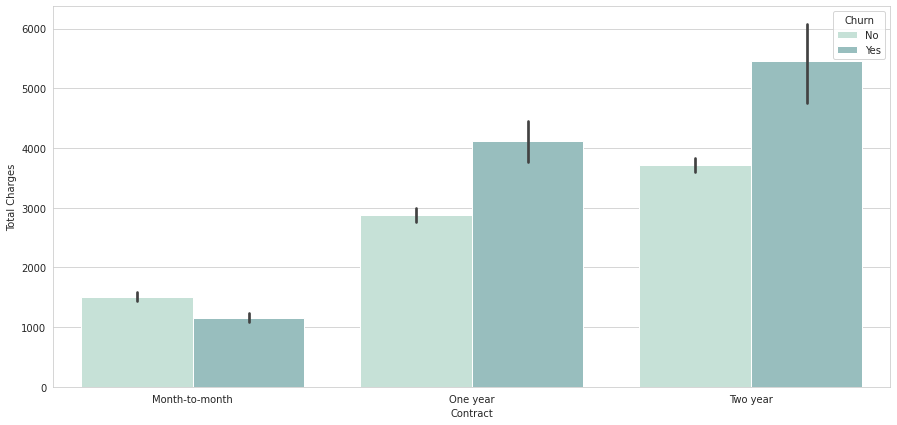

In [17]:
sns.barplot(data=dataset, x='Contract', y='Total Charges', hue='Churn')

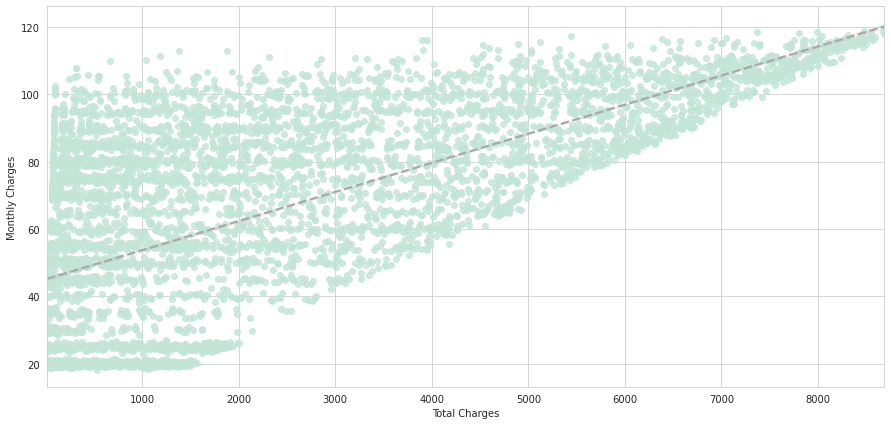

In [18]:
sns.regplot(data=dataset, y='Monthly Charges', x='Total Charges', 
            line_kws={'color': 'darkgray', 'ls': '--'})

### 2.3 Dummies Variables

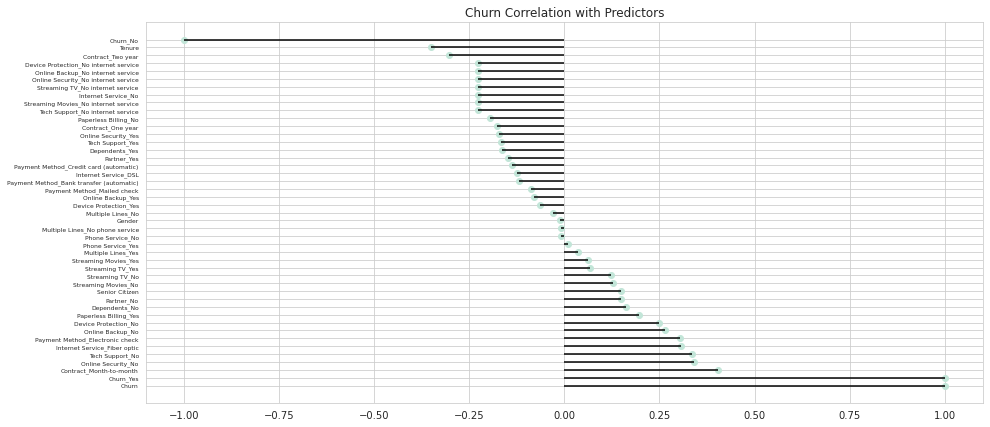

In [19]:
dummies = pd.get_dummies(dataset.drop(columns = numerical_cols + ['CustomerID']))
dummies['Churn'] = np.where(dataset.Churn == 'Yes', 1, 0)
churn_corr = dummies.corr()['Churn'].sort_values(ascending = False)
plt.hlines(y=churn_corr.index, xmin=0, xmax=churn_corr.values)
plt.scatter(y=churn_corr.index, x=churn_corr.values)
plt.title('Churn Correlation with Predictors')
plt.yticks(fontsize=6);

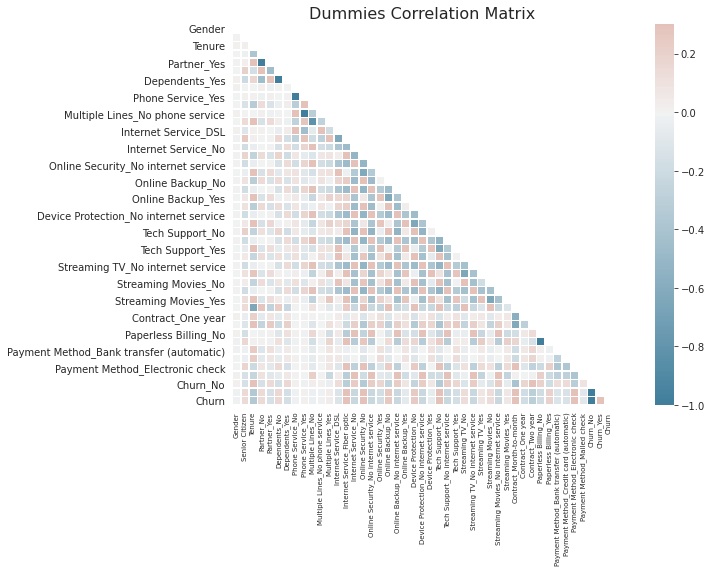

In [20]:
corr_matrix = dummies.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, annot = False)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90, fontdict={'fontsize':7})
plt.title('Dummies Correlation Matrix', fontsize=16);

### 3. Data Pre-Processing

In [21]:
features_col = numerical_cols + categorical_cols
target_col = ['Churn']

#### 3.1 Handle Missing Value
> There are only 9 rows contain miss Total Charges, we'll drop it

In [22]:
train_dataset = dataset[features_col+target_col].dropna(how='any')

#### 3.2 Encode Categorical Data

In [23]:
from sklearn.preprocessing import OrdinalEncoder

In [24]:
encode_cols = categorical_cols + target_col
encoder = OrdinalEncoder()
train_dataset[encode_cols] = encoder.fit_transform(train_dataset[encode_cols])

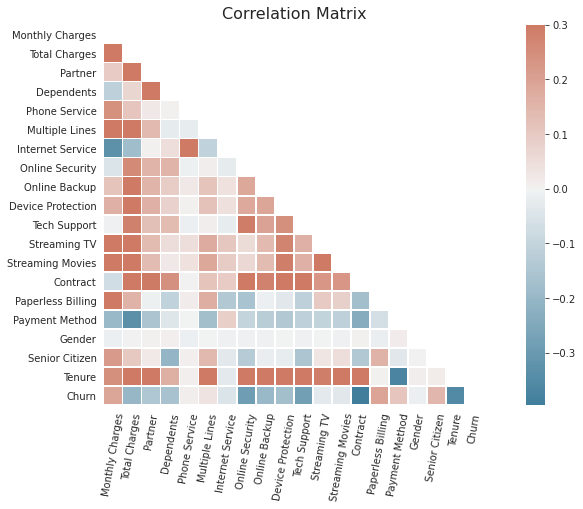

In [25]:
corr_matrix = train_dataset.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, annot = False)
fig.set_xticklabels(fig.get_xticklabels(), rotation=80)
plt.title('Correlation Matrix', fontsize=16);

#### 3.3 Standardize Data

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
scaler = StandardScaler()
train_dataset[features_col] = scaler.fit_transform(train_dataset[features_col])

#### 3.2 Data Splitting

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_val = train_test_split(train_dataset[features_col].values, test_size=0.2)
y_train, y_val = train_test_split(train_dataset[target_col[0]].values, test_size=0.2)

X_train.shape, y_train.shape

((5192, 19), (5192,))

### 4. Model

In [30]:
! pip install scikit-plot --quiet

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

import scikitplot

In [33]:
def plot_feature_importances(clf, n_features=16):
  data = pd.DataFrame(clf.feature_importances_, index=features_col, columns=['imp']).sort_values('imp', ascending=False).head(n_features)
  plt.barh(data.index, width=data.imp, ax=ax)

#### 4.1 Decision Tree Classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
min_samples_split = range(5, 206, 10)
scoring = {'AUC':'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  {'min_samples_split': min_samples_split}, 
                  scoring=scoring,
                  return_train_score=True, refit='AUC')

gs.fit(X_train, y_train)
gs_results = gs.cv_results_

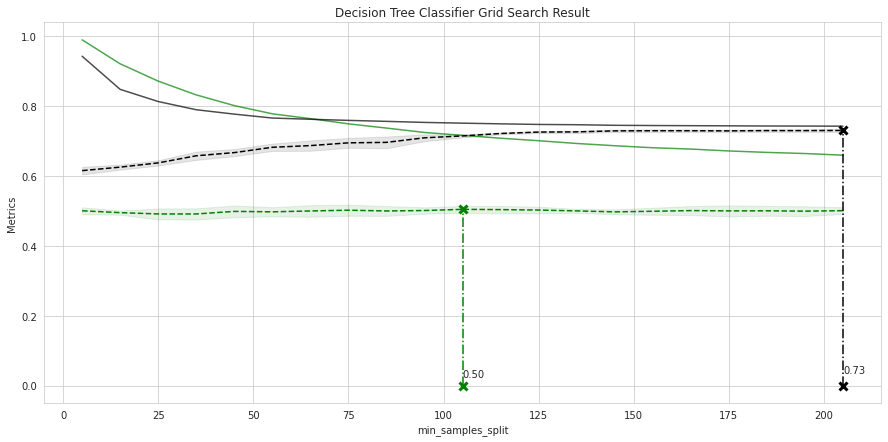

In [36]:
f, ax = plt.subplots(1)
plt.title('Decision Tree Classifier Grid Search Result')
plt.xlabel("min_samples_split")
plt.ylabel("Metrics")

for scorer, color in zip(sorted(scoring), ['g', 'k']):
  for data, ls in (('train', '-'), ('test', '--')):
    avg_score = gs_results[f'mean_{data}_{scorer}']
    std_score = gs_results[f'std_{data}_{scorer}']
    ax.fill_between(min_samples_split, avg_score - std_score,
                    avg_score + std_score,
                    alpha=0.1 if data == 'test' else 0, color=color)
    ax.plot(min_samples_split, avg_score, ls=ls, color=color,
                alpha=1 if data == 'test' else 0.7,
                label=f"{data} {scorer}")

  best_index = np.nonzero(gs_results[f'rank_test_{scorer}'] == 1)[0][0]
  best_score = gs_results[f'mean_test_{scorer}'][best_index]


  ax.plot([min_samples_split[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)
  ax.annotate("%0.2f" % best_score, (min_samples_split[best_index], best_score * 0.05))


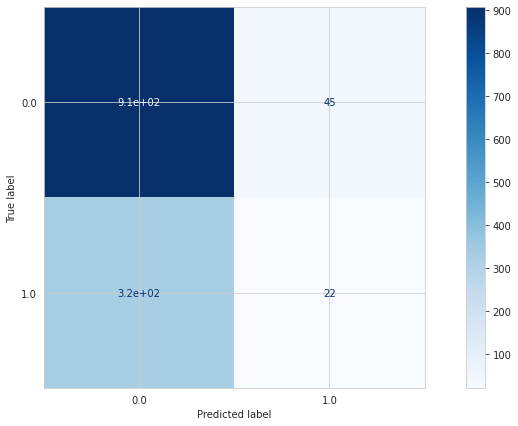

In [37]:
dct_clf = gs.best_estimator_
plot_confusion_matrix(dct_clf, X_val, y_val, cmap=plt.cm.Blues)

In [39]:
print(classification_report(y_val, dct_clf.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.74      0.95      0.83       952
         1.0       0.33      0.06      0.11       346

    accuracy                           0.72      1298
   macro avg       0.53      0.51      0.47      1298
weighted avg       0.63      0.72      0.64      1298



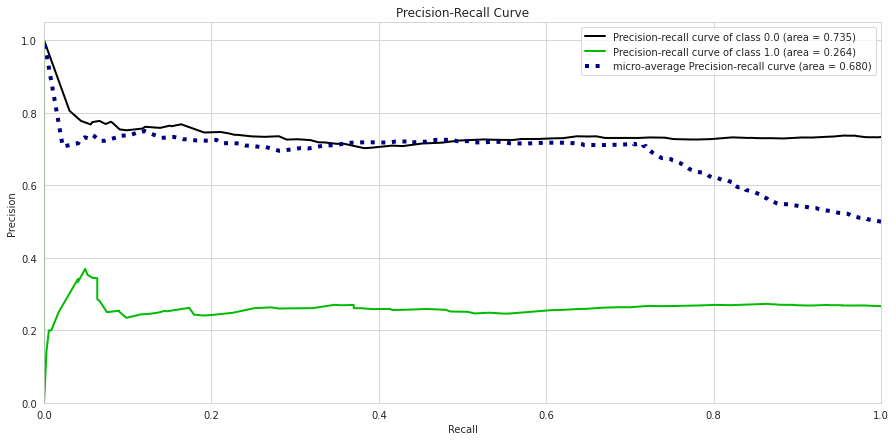

In [42]:
scikitplot.metrics.plot_precision_recall(y_val, dct_clf.predict_proba(X_val))

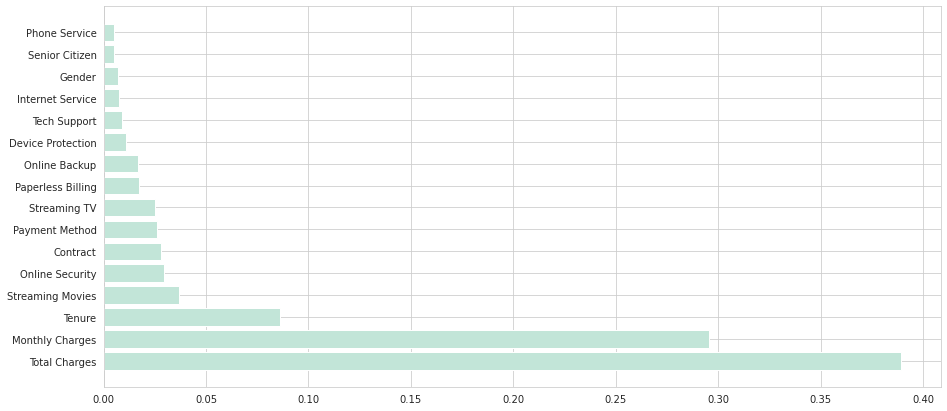

In [44]:
plot_feature_importances(dct_clf)

#### 4.2 Gradient Boosting Classifier

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

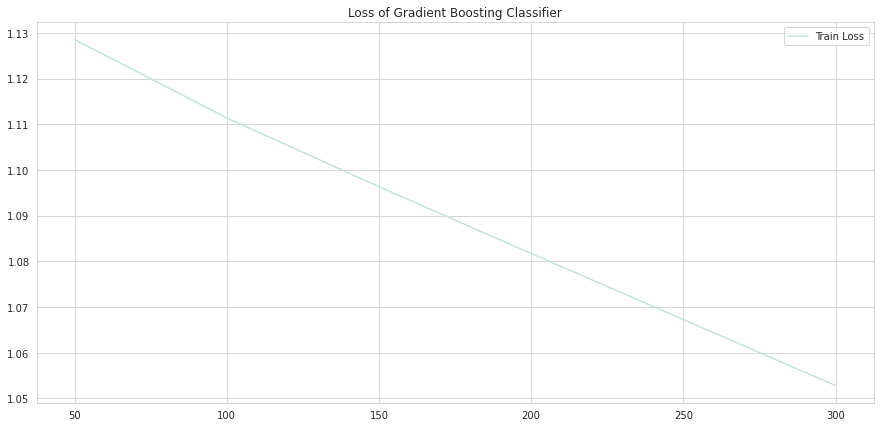

In [46]:
n_estimators = range(50, 350, 50)
losses = []

for n_estimator in n_estimators:
  clf = GradientBoostingClassifier(n_estimators=n_estimator)
  clf.fit(X_train, y_train)
  losses.append(np.mean(clf.train_score_));

plt.title('Loss of Gradient Boosting Classifier');
sns.lineplot(x=n_estimators, y=losses, label='Train Loss');

In [47]:
gbc = GradientBoostingClassifier(n_estimators=350)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=350,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

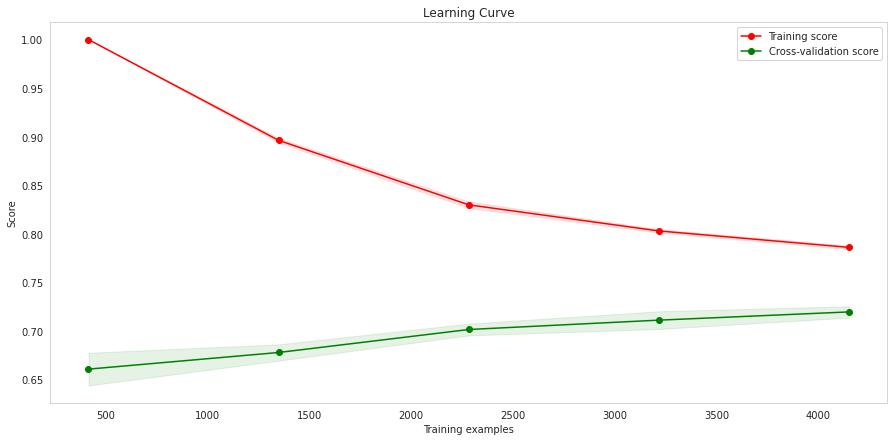

In [48]:
scikitplot.estimators.plot_learning_curve(gbc, X_train, y_train)

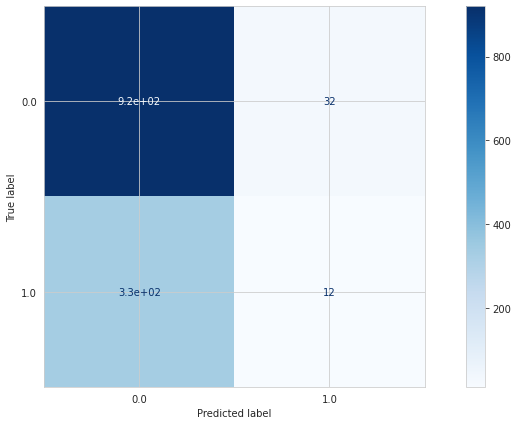

In [49]:
plot_confusion_matrix(gbc, X_val, y_val, cmap=plt.cm.Blues)

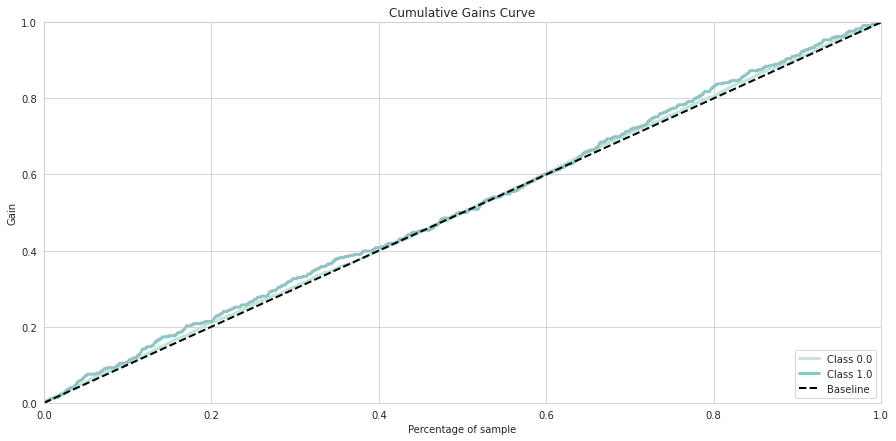

In [52]:
scikitplot.metrics.plot_cumulative_gain(y_val, clf.predict_proba(X_val))

In [53]:
print(classification_report(y_val, clf.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.73      0.97      0.84       952
         1.0       0.31      0.03      0.06       346

    accuracy                           0.72      1298
   macro avg       0.52      0.50      0.45      1298
weighted avg       0.62      0.72      0.63      1298



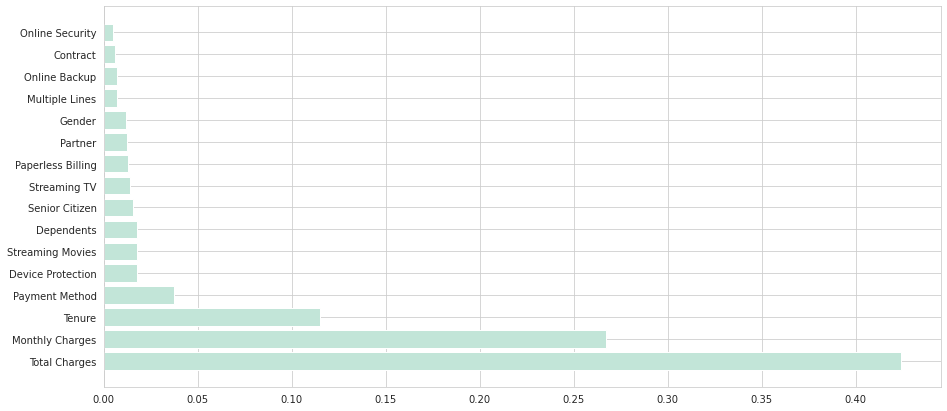

In [54]:
plot_feature_importances(clf)

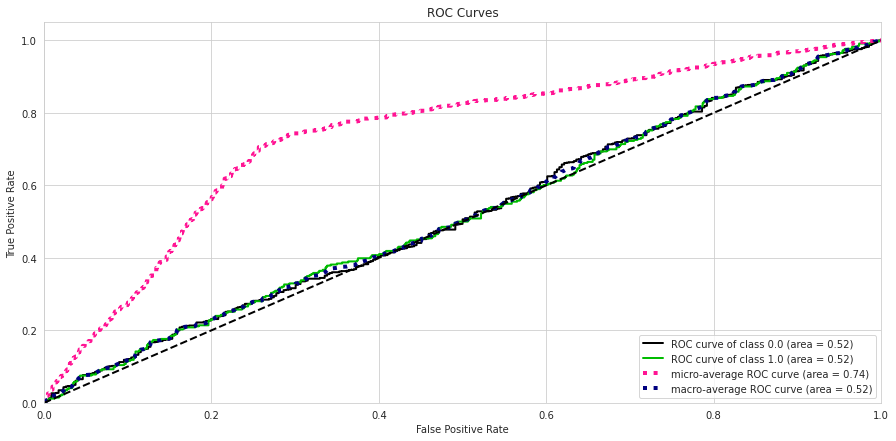

In [55]:
scikitplot.metrics.plot_roc(y_val, clf.predict_proba(X_val))

#### Calibration

Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level

In [56]:
from sklearn.calibration import calibration_curve

In [57]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [58]:
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier()

clfs = {lr: 'Logistic Regression',
        gnb: 'Naive Bayes',
        svc: 'Support Vector Classification',
        rfc: 'Random Forest'}

3


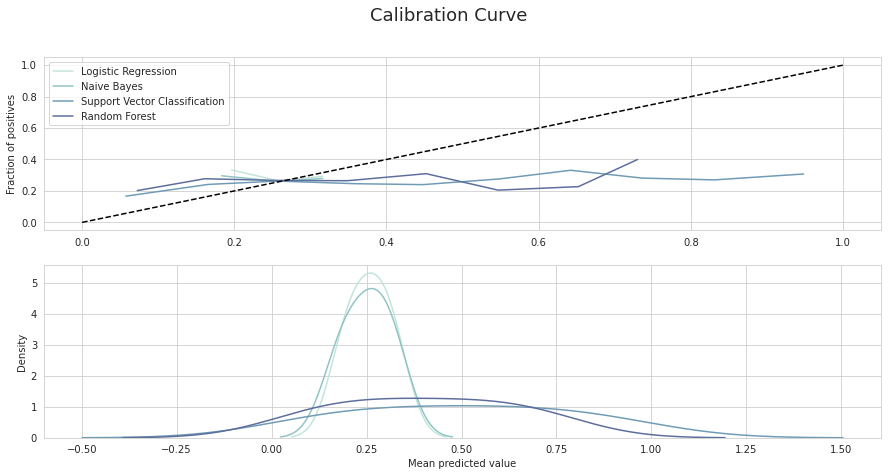

In [59]:
f, ax = plt.subplots(2, 1)

for clf, name in clfs.items():
  clf.fit(X_train, y_train)
  if hasattr(clf, "predict_proba"):
    prob = clf.predict_proba(X_val)[:, 1]
  else:
    prob = clf.decision_function(X_val)
    prob = (prob - prob.min()) / (prob.max() - prob.min())

  positives_fraction, avg_predicted_value = calibration_curve(y_val, prob, n_bins=10)
  if name == 'Naive Bayes':
    print(len(avg_predicted_value))
  sns.lineplot(x=avg_predicted_value, y=positives_fraction, label=name, ax=ax[0])
  sns.kdeplot(x=avg_predicted_value, label=name, ax=ax[1])


ax[0].plot([0, 1], [0, 1], "k--")
plt.suptitle('Calibration Curve');
ax[0].set_ylabel("Fraction of positives");
ax[1].set_xlabel("Mean predicted value");

### 5. Making Predictions on Test Dataset

In [60]:
test_data = pd.read_csv('test.csv')
test_data.head()

,CustomerID,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,2676-ISHSF,1,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.30,20.30
1,9236-NDUCW,0,0,No,No,21,No,No phone service,DSL,Yes,No,No,Yes,No,No,Two year,No,Mailed check,35.10,770.40
2,4753-PADAS,0,0,Yes,No,67,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),105.70,6816.95
3,6103-QCKFX,0,0,Yes,Yes,44,Yes,No,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Bank transfer (automatic),56.25,2419.55
4,7781-EWARA,1,0,Yes,Yes,70,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,One year,No,Electronic check,60.35,4138.70


In [61]:
test_data.columns[test_data.isna().sum() > 1]

Index(['Total Charges'], dtype='object')

#### 5.1 Pre-Processing

In [62]:
X_test = test_data.drop(columns=['CustomerID'])

Impute the missing value

In [63]:
from sklearn.preprocessing import OrdinalEncoder

In [64]:
from sklearn.impute import SimpleImputer

In [65]:
nan_col = X_test.columns[X_test.isna().sum() > 1]
imputer = SimpleImputer(strategy='mean')
X_test[nan_col] = imputer.fit_transform(X_test[nan_col])

Encode the data

In [66]:
encoder = OrdinalEncoder()
X_test = encoder.fit_transform(X_test)

In [67]:
dct_clf.predict(X_test)[:10]

array([1., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

#### 5.2 Making Prediction

In [68]:
test_data['DecisonTreeClassfier Prediction'] = dct_clf.predict(X_test).astype(int)
test_data['GradientBoostingClassfier Prediction'] = gbc.predict(X_test).astype(int)

In [69]:
test_data.head()

,CustomerID,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,DecisonTreeClassfier Prediction,GradientBoostingClassfier Prediction
0,2676-ISHSF,1,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.30,20.30,1,0
1,9236-NDUCW,0,0,No,No,21,No,No phone service,DSL,Yes,No,No,Yes,No,No,Two year,No,Mailed check,35.10,770.40,0,0
2,4753-PADAS,0,0,Yes,No,67,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),105.70,6816.95,0,0
3,6103-QCKFX,0,0,Yes,Yes,44,Yes,No,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Bank transfer (automatic),56.25,2419.55,0,0
4,7781-EWARA,1,0,Yes,Yes,70,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,One year,No,Electronic check,60.35,4138.70,1,0


### Reference

In [70]:
# https://github.com/pik1989/MLProject-ChurnPrediction/blob/main/Churn%20Analysis%20-%20Model%20Building.ipynb